<a href="https://colab.research.google.com/github/SayanDas07/KWS-using-FewShotLearning/blob/main/FineTuneTFmodel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

10+3 Classes classifiers .... samples of 13..+ FT... brining the TL model from drive07. file name TL(only 3keywords).ipynb

In [1]:
!nvidia-smi

Fri Jun 13 04:58:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
!wget -O speech_commands_v0.02.tar.gz http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

--2025-06-13 04:58:56--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.107.207, 74.125.196.207, 173.194.216.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.107.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G   203MB/s    in 10s     

2025-06-13 04:59:07 (222 MB/s) - ‘speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



In [5]:
!mkdir -p data_10_wav/data

In [6]:
!tar -xzf speech_commands_v0.02.tar.gz -C data_10_wav/data

In [82]:
DATASET_PATH = "data_10_wav/data/"
save_path = "/content/drive/MyDrive/NITDGP/TL Variations /10+3Classes"

In [83]:
SAMPLES_TO_CONSIDER = 16000
frame_length = int(SAMPLES_TO_CONSIDER * (32 / 1000))
hop_length = int(SAMPLES_TO_CONSIDER * (16 / 1000))


os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(save_path, exist_ok=True)

In [84]:
print("frame_length:", frame_length)
print("hop_length:", hop_length)

frame_length: 512
hop_length: 256


In [85]:
new_keywords = ['tree', 'marvin', 'one']
keyword_list = ['off', 'left', 'down', 'up', 'go', 'on', 'stop', 'right', 'yes']
all_keywords = new_keywords + keyword_list
existing_keyword_index = {k: i for i, k in enumerate(keyword_list)}
new_keyword_index = {k: i + len(keyword_list) for i, k in enumerate(new_keywords)}
print(existing_keyword_index)
print(new_keyword_index)


{'off': 0, 'left': 1, 'down': 2, 'up': 3, 'go': 4, 'on': 5, 'stop': 6, 'right': 7, 'yes': 8}
{'tree': 9, 'marvin': 10, 'one': 11}


In [86]:
def hamming_window(length):
    return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(length) / (length - 1))

In [87]:
labels = []
log_mel_spectrograms = []

In [88]:
class_sample_counts = {kw: 0 for kw in all_keywords}

In [89]:
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    label = os.path.basename(dirpath)
    if label not in all_keywords:
        continue

    max_samples = 500 if label in new_keywords else 300
    print(f"\nProcessing: '{label}' (Max {max_samples} samples)")

    for f in filenames:
        file_path = os.path.join(dirpath, f)
        try:
            signal, _ = librosa.load(file_path, sr=16000)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue

        if len(signal) >= SAMPLES_TO_CONSIDER:
            signal = signal[:SAMPLES_TO_CONSIDER]
        else:
            signal = np.pad(signal, (SAMPLES_TO_CONSIDER - len(signal), 0), mode='constant')

        signal = signal.astype(np.float32)
        windowed = signal * hamming_window(SAMPLES_TO_CONSIDER)

        mel_spec = librosa.feature.melspectrogram(
            y=windowed,
            sr=16000,
            n_mels=40,
            n_fft=frame_length,
            win_length=frame_length,
            hop_length=hop_length,
            center=False
        )

        log_mel = librosa.power_to_db(mel_spec, ref=np.max)
        log_mel_spectrograms.append(log_mel.T)

        if label in new_keywords:
            labels.append(new_keyword_index[label])
        else:
            labels.append(existing_keyword_index[label])

        class_sample_counts[label] += 1
        if class_sample_counts[label] >= max_samples:
            break


Processing: 'up' (Max 300 samples)

Processing: 'on' (Max 300 samples)

Processing: 'down' (Max 300 samples)

Processing: 'one' (Max 500 samples)

Processing: 'off' (Max 300 samples)

Processing: 'stop' (Max 300 samples)

Processing: 'left' (Max 300 samples)

Processing: 'right' (Max 300 samples)

Processing: 'tree' (Max 500 samples)

Processing: 'marvin' (Max 500 samples)

Processing: 'yes' (Max 300 samples)

Processing: 'go' (Max 300 samples)


In [90]:
np.save(os.path.join(save_path, 'X_log_mel_spectrograms_TL3.npy'), np.array(log_mel_spectrograms))
np.save(os.path.join(save_path, 'y_log_mel_spectrograms_TL3.npy'), np.array(labels))
print("Feature extraction done and saved.")


Feature extraction done and saved.


In [91]:
X = np.load(os.path.join(save_path, 'X_log_mel_spectrograms_TL3.npy'))
y = np.load(os.path.join(save_path, 'y_log_mel_spectrograms_TL3.npy'))

In [92]:
print("X shape:", X.shape)  # (num_samples, time_steps, n_mels)
print("y shape:", y.shape)  # (num_samples,)


X shape: (4200, 61, 40)
y shape: (4200,)


In [140]:
from collections import Counter

# Combine both mappings: new + existing
keyword_to_index = {**existing_keyword_index, **new_keyword_index}
inv_label_map = {v: k for k, v in keyword_to_index.items()}

# Assuming `y` contains class indices (0–12)
label_counts = Counter(y)

for label_idx in sorted(label_counts):
    label_name = inv_label_map.get(label_idx, 'unknown')
    print(f"{label_name}: {label_counts[label_idx]} samples")


off: 300 samples
left: 300 samples
down: 300 samples
up: 300 samples
go: 300 samples
on: 300 samples
stop: 300 samples
right: 300 samples
yes: 300 samples
tree: 500 samples
marvin: 500 samples
one: 500 samples


In [141]:
# Normalize
X = np.array([x / np.max(np.abs(x)) if np.max(np.abs(x)) > 0 else x for x in X])

# ✅ Remove extra dims and reshape correctly
X = np.squeeze(X)  # removes all dimensions of size 1, if any
if X.ndim == 3:
    X = X[..., np.newaxis]  # adds only (61, 40, 1) as required
y_cat = to_categorical(y, 13)

In [142]:
print("X shape:", X.shape)  # (num_samples, time_steps, n_mels)
print("y shape:", y.shape)  # (num_samples,)


X shape: (4200, 61, 40, 1)
y shape: (4200,)


In [143]:
tf_model = load_model("/content/CNN_TLMODE.h5")

In [144]:
for i, layer in enumerate(tf_model.layers):
    print(i, layer.name)


0 input_layer
1 conv2d
2 relu1_1
3 conv2d_1
4 relu1_2
5 max_pooling2d
6 conv2d_3
7 re_lu
8 conv2d_4
9 conv2d_2
10 max_pooling2d_1
11 batch_normalization
12 add
13 res_relu_0
14 gap
15 fc1
16 dropout1
17 fc2
18 dropout2
19 fc3
20 dropout3
21 fc4
22 dropout4
23 fc5
24 dropout5
25 fc6
26 dropout6
27 fc7
28 dropout7
29 output


In [145]:
# Unfreeze from fc2 (index 17) onward
for i, layer in enumerate(tf_model.layers):
    layer.trainable = (i >= 17)


In [146]:
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.optimizers import Adam
optimizer = optimizers.Adam(learning_rate=1e-4)

In [147]:
tf_model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [148]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "/content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5"
ckpt = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [149]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

In [150]:
history = tf_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[ckpt, early_stop],
    verbose=1
)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1250 - loss: 12.5588
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.1251 - loss: 12.5284 - val_accuracy: 0.2000 - val_loss: 3.5046
Epoch 2/50
 98/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1423 - loss: 4.1096
Epoch 2: val_accuracy improved from 0.20000 to 0.24167, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1433 - loss: 4.0697 - val_accuracy: 0.2417 - val_loss: 2.1823
Epoch 3/50
 99/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1945 - loss: 2.6308
Epoch 3: val_accuracy improved from 0.24167 to 0.37738, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1961 - loss: 2.6242 - val_accuracy: 0.3774 - val_loss: 2.0257
Epoch 4/50
101/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2516 - loss: 2.2812
Epoch 4: val_accuracy improved from 0.37738 to 0.48571, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2517 - loss: 2.2792 - val_accuracy: 0.4857 - val_loss: 1.8685
Epoch 5/50
 99/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3121 - loss: 2.0902
Epoch 5: val_accuracy improved from 0.48571 to 0.68333, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3129 - loss: 2.0867 - val_accuracy: 0.6833 - val_loss: 1.6830
Epoch 6/50
102/105 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3922 - loss: 1.8325
Epoch 6: val_accuracy improved from 0.68333 to 0.76548, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3919 - loss: 1.8327 - val_accuracy: 0.7655 - val_loss: 1.4631
Epoch 7/50
 97/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4224 - loss: 1.7061
Epoch 7: val_accuracy improved from 0.76548 to 0.78571, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4240 - loss: 1.7022 - val_accuracy: 0.7857 - val_loss: 1.2371
Epoch 8/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5018 - loss: 1.5304
Epoch 8: val_accuracy improved from 0.78571 to 0.79405, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5020 - loss: 1.5292 - val_accuracy: 0.7940 - val_loss: 1.0171
Epoch 9/50
101/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5443 - loss: 1.3248
Epoch 9: val_accuracy did not improve from 0.79405
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5448 - loss: 1.3239 - val_accuracy: 0.7679 - val_loss: 0.8496
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5994 - loss: 1.1821
Epoch 10: val_accuracy improved from 0.79405 to 0.82619, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5995 - loss: 1.1817 - val_accuracy: 0.8262 - val_loss: 0.7399
Epoch 11/50
101/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6474 - loss: 1.0741
Epoch 11: val_accuracy improved from 0.82619 to 0.86190, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6474 - loss: 1.0723 - val_accuracy: 0.8619 - val_loss: 0.6605
Epoch 12/50
 95/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6745 - loss: 0.9924
Epoch 12: val_accuracy did not improve from 0.86190
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6748 - loss: 0.9884 - val_accuracy: 0.8179 - val_loss: 0.6114
Epoch 13/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6640 - loss: 0.9400
Epoch 13: val_accuracy did not improve from 0.86190
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6655 - loss: 0.9367 - val_accuracy: 0.8417 - val_loss: 0.5737
Epoch 14/50
102/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7063 - loss: 0.8513
Epoch 14: val_accuracy did not improve from 0.86190
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7067 - loss: 0.8496 - val_accuracy: 0.8238 - val_loss: 0.5406
Epoch 15/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7183 - loss: 0.7987
Epoch 15: val_accuracy did n

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7748 - loss: 0.6585 - val_accuracy: 0.8631 - val_loss: 0.4400
Epoch 19/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7781 - loss: 0.6119
Epoch 19: val_accuracy did not improve from 0.86310
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7781 - loss: 0.6118 - val_accuracy: 0.8619 - val_loss: 0.4271
Epoch 20/50
101/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7872 - loss: 0.5825
Epoch 20: val_accuracy improved from 0.86310 to 0.86429, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7869 - loss: 0.5827 - val_accuracy: 0.8643 - val_loss: 0.4179
Epoch 21/50
103/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8002 - loss: 0.5744
Epoch 21: val_accuracy did not improve from 0.86429
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8002 - loss: 0.5746 - val_accuracy: 0.8643 - val_loss: 0.4109
Epoch 22/50
 97/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8025 - loss: 0.5542
Epoch 22: val_accuracy improved from 0.86429 to 0.87024, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8024 - loss: 0.5541 - val_accuracy: 0.8702 - val_loss: 0.4014
Epoch 23/50
101/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8044 - loss: 0.5363
Epoch 23: val_accuracy did not improve from 0.87024
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8041 - loss: 0.5379 - val_accuracy: 0.8643 - val_loss: 0.3985
Epoch 24/50
 98/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8133 - loss: 0.5506
Epoch 24: val_accuracy improved from 0.87024 to 0.87500, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8133 - loss: 0.5487 - val_accuracy: 0.8750 - val_loss: 0.3898
Epoch 25/50
101/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8143 - loss: 0.5075
Epoch 25: val_accuracy did not improve from 0.87500
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8142 - loss: 0.5073 - val_accuracy: 0.8750 - val_loss: 0.3850
Epoch 26/50
 99/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8192 - loss: 0.5034
Epoch 26: val_accuracy improved from 0.87500 to 0.87738, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8193 - loss: 0.5029 - val_accuracy: 0.8774 - val_loss: 0.3804
Epoch 27/50
103/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8203 - loss: 0.5071
Epoch 27: val_accuracy improved from 0.87738 to 0.88452, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8206 - loss: 0.5063 - val_accuracy: 0.8845 - val_loss: 0.3743
Epoch 28/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8208 - loss: 0.4992
Epoch 28: val_accuracy did not improve from 0.88452
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8212 - loss: 0.4979 - val_accuracy: 0.8821 - val_loss: 0.3763
Epoch 29/50
103/105 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8224 - loss: 0.4944
Epoch 29: val_accuracy improved from 0.88452 to 0.89048, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8225 - loss: 0.4939 - val_accuracy: 0.8905 - val_loss: 0.3675
Epoch 30/50
102/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8473 - loss: 0.4327
Epoch 30: val_accuracy did not improve from 0.89048
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8470 - loss: 0.4332 - val_accuracy: 0.8905 - val_loss: 0.3600
Epoch 31/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8387 - loss: 0.4554
Epoch 31: val_accuracy improved from 0.89048 to 0.89286, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8391 - loss: 0.4543 - val_accuracy: 0.8929 - val_loss: 0.3537
Epoch 32/50
101/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8473 - loss: 0.4545
Epoch 32: val_accuracy improved from 0.89286 to 0.90119, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8474 - loss: 0.4537 - val_accuracy: 0.9012 - val_loss: 0.3508
Epoch 33/50
101/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8488 - loss: 0.4704
Epoch 33: val_accuracy did not improve from 0.90119
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8490 - loss: 0.4686 - val_accuracy: 0.9012 - val_loss: 0.3438
Epoch 34/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8559 - loss: 0.3992
Epoch 34: val_accuracy did not improve from 0.90119
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8560 - loss: 0.3996 - val_accuracy: 0.8988 - val_loss: 0.3372
Epoch 35/50
103/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8822 - loss: 0.3878
Epoch 35: val_accuracy did not improve from 0.90119
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8820 - loss: 0.3880 - val_accuracy: 0.8988 - val_loss: 0.3302
Epoch 36/50
101/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8569 - loss: 0.3949
Epoch 36: val_accuracy impro

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8571 - loss: 0.3955 - val_accuracy: 0.9024 - val_loss: 0.3249
Epoch 37/50
 99/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8746 - loss: 0.3812
Epoch 37: val_accuracy improved from 0.90238 to 0.90357, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8742 - loss: 0.3815 - val_accuracy: 0.9036 - val_loss: 0.3188
Epoch 38/50
102/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8732 - loss: 0.3985
Epoch 38: val_accuracy did not improve from 0.90357
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8733 - loss: 0.3978 - val_accuracy: 0.8988 - val_loss: 0.3145
Epoch 39/50
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8804 - loss: 0.3705
Epoch 39: val_accuracy did not improve from 0.90357
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8806 - loss: 0.3701 - val_accuracy: 0.9036 - val_loss: 0.3071
Epoch 40/50
103/105 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8880 - loss: 0.3424
Epoch 40: val_accuracy improved from 0.90357 to 0.90714, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8879 - loss: 0.3428 - val_accuracy: 0.9071 - val_loss: 0.3040
Epoch 41/50
101/105 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8778 - loss: 0.3855
Epoch 41: val_accuracy improved from 0.90714 to 0.90952, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8783 - loss: 0.3839 - val_accuracy: 0.9095 - val_loss: 0.2989
Epoch 42/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8990 - loss: 0.3658
Epoch 42: val_accuracy did not improve from 0.90952
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8989 - loss: 0.3658 - val_accuracy: 0.9095 - val_loss: 0.2957
Epoch 43/50
 99/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9056 - loss: 0.3279
Epoch 43: val_accuracy did not improve from 0.90952
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9055 - loss: 0.3291 - val_accuracy: 0.9095 - val_loss: 0.2924
Epoch 44/50
 98/105 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9001 - loss: 0.3235
Epoch 44: val_accuracy did not improve from 0.90952
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9000 - loss: 0.3246 - val_accuracy: 0.9083 - val_loss: 0.2913
Epoch 45/50
 99/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8925 - loss: 0.3261
Epoch 45: val_accuracy impr

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8928 - loss: 0.3266 - val_accuracy: 0.9131 - val_loss: 0.2915
Epoch 46/50
101/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8891 - loss: 0.3627
Epoch 46: val_accuracy did not improve from 0.91310
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8892 - loss: 0.3617 - val_accuracy: 0.9119 - val_loss: 0.2875
Epoch 47/50
 98/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8872 - loss: 0.3589
Epoch 47: val_accuracy did not improve from 0.91310
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8880 - loss: 0.3560 - val_accuracy: 0.9131 - val_loss: 0.2875
Epoch 48/50
101/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9103 - loss: 0.3106
Epoch 48: val_accuracy improved from 0.91310 to 0.91429, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9102 - loss: 0.3118 - val_accuracy: 0.9143 - val_loss: 0.2841
Epoch 49/50
 99/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9071 - loss: 0.3005
Epoch 49: val_accuracy did not improve from 0.91429
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9071 - loss: 0.3004 - val_accuracy: 0.9143 - val_loss: 0.2812
Epoch 50/50
101/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9127 - loss: 0.2990
Epoch 50: val_accuracy improved from 0.91429 to 0.91548, saving model to /content/drive/MyDrive/NITDGP/TL Variations /10+3Classes/FT_model_13class.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9124 - loss: 0.2999 - val_accuracy: 0.9155 - val_loss: 0.2809


In [74]:
test_loss, test_accuracy = tf_model.evaluate(X_val, y_val, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9486 - loss: 0.2773
Test Accuracy: 0.95


In [151]:
loss, acc = tf_model.evaluate(X_val, y_val)
print(f"\nTest Accuracy: {acc * 100:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9110 - loss: 0.3036

Test Accuracy: 91.55%


In [152]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


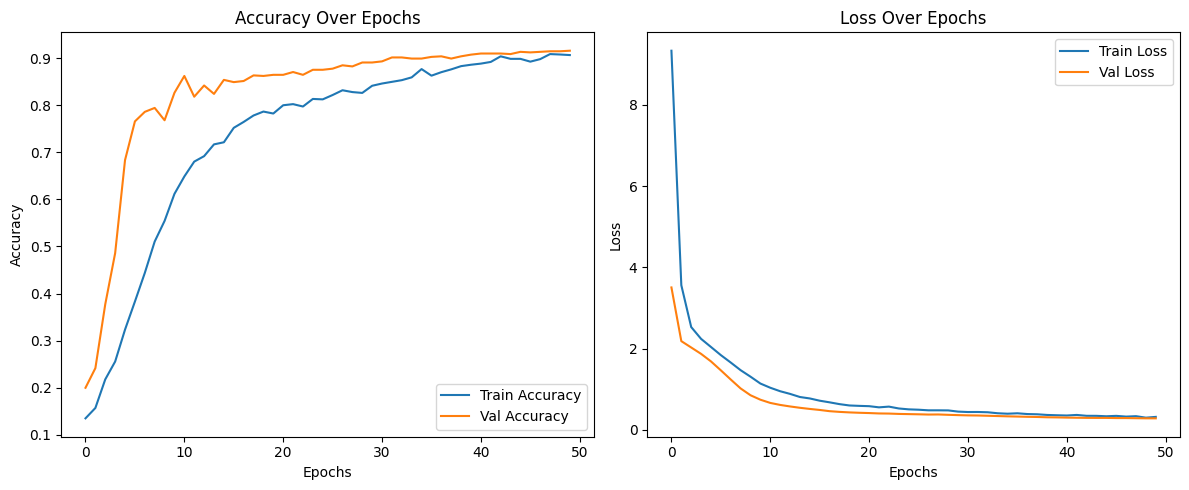

In [153]:
plot_training_history(history)

In [154]:
y_pred = tf_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [155]:
print(classification_report(y_true_classes, y_pred_classes, target_names=all_keywords))

              precision    recall  f1-score   support

        tree       0.94      0.98      0.96        60
      marvin       0.91      0.88      0.90        60
         one       0.98      0.95      0.97        60
         off       0.95      0.92      0.93        60
        left       0.97      0.93      0.95        60
        down       0.92      0.95      0.93        60
          up       1.00      0.98      0.99        60
          go       0.97      0.97      0.97        60
          on       1.00      0.97      0.98        60
        stop       0.84      0.92      0.88       100
       right       0.82      0.82      0.82       100
         yes       0.86      0.83      0.84       100

    accuracy                           0.92       840
   macro avg       0.93      0.93      0.93       840
weighted avg       0.92      0.92      0.92       840



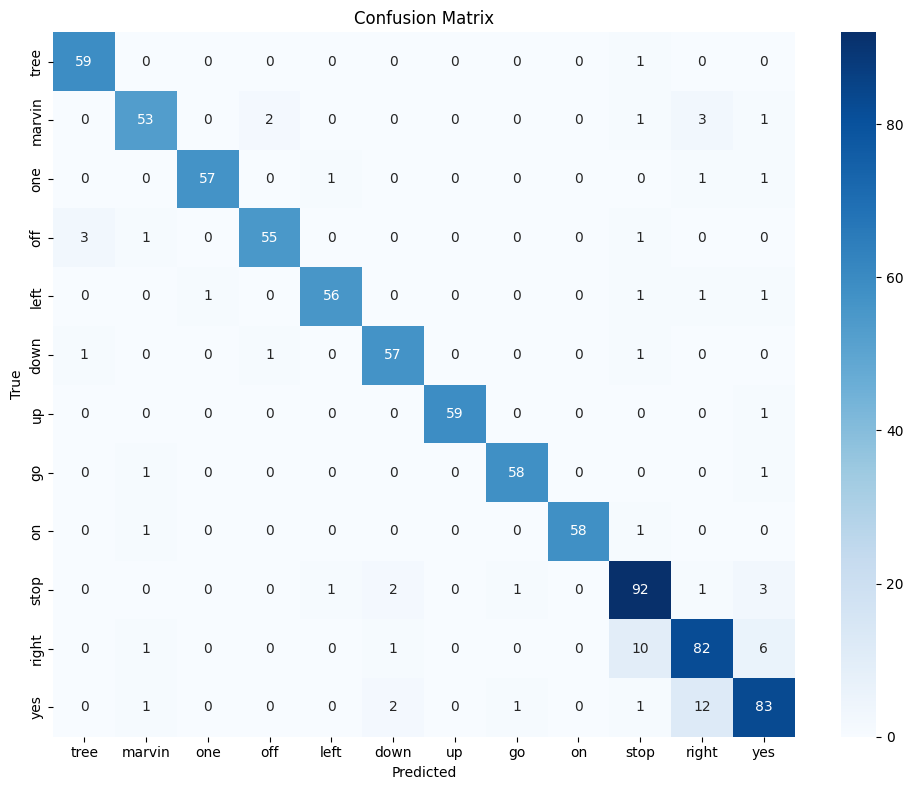

In [156]:
import seaborn as sns

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_keywords, yticklabels=all_keywords)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
